Reference
* https://www.kaggle.com/hirayukis/pytorch-lstm-cv-0-1942-lb-0-193
  * 242,5729
* https://www.kaggle.com/dienhoa/ventillator-fastai-lb-0-168-no-kfolds-no-blend?scriptVersionId=78176083
  * 1051,2501

In [1]:
import gc
import time
import argparse
from fastai.layers import swish

import numpy as np
import pandas as pd

from sklearn.model_selection import KFold

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary

from fastai.callback.schedule import Learner
from fastai.data.core import DataLoaders
from fastai.losses import L1LossFlat
from fastai.callback.core import Callback
from fastai.callback.tracker import ReduceLROnPlateau, SaveModelCallback

from HW_base import evaluate_build, focus_build
from HW_torch import dataLoads_build, net_parameter_count, hw_layer
from HW_torch import torch_valid, torch_predict

In [2]:
fname = 'F25_LSTM(500-400-300-200)_(FC-SELU-FC)'
epoch_num = 350
batch_size = 512

In [3]:
class RNNModel(nn.Module):
    def __init__(self, input_size=25):
        hidden = [500, 400, 300, 200]
        super().__init__()
        self.lstm1 = nn.LSTM(input_size, hidden[0],
                             batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(2 * hidden[0], hidden[1],
                             batch_first=True, bidirectional=True)
        self.lstm3 = nn.LSTM(2 * hidden[1], hidden[2],
                             batch_first=True, bidirectional=True)
        self.lstm4 = nn.LSTM(2 * hidden[2], hidden[3],
                             batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(2 * hidden[3], 50)
        self.selu = nn.SELU()
        self.fc2 = nn.Linear(50, 1)
        self._reinitialize()

    def _reinitialize(self):
        """
        Tensorflow/Keras-like initialization
        """
        for name, p in self.named_parameters():
            if 'lstm' in name:
                if 'weight_ih' in name:
                    nn.init.xavier_uniform_(p.data)
                elif 'weight_hh' in name:
                    nn.init.orthogonal_(p.data)
                elif 'bias_ih' in name:
                    p.data.fill_(0)
                    # Set forget-gate bias to 1
                    n = p.size(0)
                    p.data[(n // 4):(n // 2)].fill_(1)
                elif 'bias_hh' in name:
                    p.data.fill_(0)
            elif 'fc' in name:
                if 'weight' in name:
                    nn.init.xavier_uniform_(p.data)
                elif 'bias' in name:
                    p.data.fill_(0)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x, _ = self.lstm3(x)
        x, _ = self.lstm4(x)
        x = self.fc1(x)
        x = self.selu(x)
        x = self.fc2(x)

        return x

In [4]:
data_train_df = pd.read_csv('./Database/train.csv')
data_test_df = pd.read_csv('./Database/test.csv')

In [5]:
def add_features(df):
    df['area'] = df['time_step'] * df['u_in']
    df['area'] = df.groupby('breath_id')['area'].cumsum()
    df['cross']= df['u_in']*df['u_out']
    df['cross2']= df['time_step']*df['u_out']
    
    df['u_in_cumsum'] = (df['u_in']).groupby(df['breath_id']).cumsum()
    df['one'] = 1
    df['count'] = (df['one']).groupby(df['breath_id']).cumsum()
    df['u_in_cummean'] =df['u_in_cumsum'] /df['count']
    df['breath_id_lag']=df['breath_id'].shift(1).fillna(0)
    df['breath_id_lag2']=df['breath_id'].shift(2).fillna(0)
    df['breath_id_lagsame']=np.select([df['breath_id_lag']==df['breath_id']],[1],0)
    df['breath_id_lag2same']=np.select([df['breath_id_lag2']==df['breath_id']],[1],0)
    df['u_in_lag'] = df['u_in'].shift(1).fillna(0)
    df['u_in_lag'] = df['u_in_lag']*df['breath_id_lagsame']
    df['u_in_lag2'] = df['u_in'].shift(2).fillna(0)
    df['u_in_lag2'] = df['u_in_lag2']*df['breath_id_lag2same']
    df['u_out_lag2'] = df['u_out'].shift(2).fillna(0)
    df['u_out_lag2'] = df['u_out_lag2']*df['breath_id_lag2same']
    #df['u_in_lag'] = df['u_in'].shift(2).fillna(0)
    
    df['R'] = df['R'].astype(str)
    df['C'] = df['C'].astype(str)
    df['RC'] = df['R']+df['C']
    df = pd.get_dummies(df)
    return df

In [6]:
data_train_df = add_features(data_train_df)
data_test_df = add_features(data_test_df)

In [7]:
drop_columns = ['pressure','id', 'breath_id','one','count','breath_id_lag','breath_id_lag2','breath_id_lagsame','breath_id_lag2same','u_out_lag2']
x_columns = [col for col in data_train_df.columns if col not in drop_columns]
y_columns = ['pressure']

In [8]:
data_train = data_train_df[x_columns].values.astype(np.float32)
data_train = data_train.reshape(-1, 80, data_train.shape[-1])

target_train = data_train_df[y_columns].values.astype(np.float32)
target_train = target_train.reshape(-1, 80, target_train.shape[-1])

data_test = data_test_df[x_columns].values.astype(np.float32)
data_test = data_test.reshape(-1, 80, data_test.shape[-1])

In [9]:
print(data_train.shape)

(75450, 80, 25)


In [10]:
np.random.seed(121212)
data_idx = np.arange(len(data_train))
np.random.shuffle(data_idx)

train_index = data_idx[:int(len(data_idx)*0.8)]
valid_index = data_idx[int(len(data_idx)*0.8):]

print(len(train_index), len(valid_index))

x_train, y_train = data_train[train_index], target_train[train_index]
x_valid, y_valid = data_train[valid_index], target_train[valid_index]
x_test = data_test

60360 15090


In [11]:
del data_train_df
del data_test_df
gc.collect()

22

In [12]:
model = RNNModel()
print(model)

train_parameter_num, freeze_parameter_num = net_parameter_count(model)
print(train_parameter_num, freeze_parameter_num)

RNNModel(
  (lstm1): LSTM(25, 500, batch_first=True, bidirectional=True)
  (lstm2): LSTM(1000, 400, batch_first=True, bidirectional=True)
  (lstm3): LSTM(800, 300, batch_first=True, bidirectional=True)
  (lstm4): LSTM(600, 200, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=400, out_features=50, bias=True)
  (selu): SELU()
  (fc2): Linear(in_features=50, out_features=1, bias=True)
)
10542501 0


In [13]:
def train_submission(epoch_num, batch_size):
    dataLoads = dataLoads_build(x_train, y_train, x_valid, y_valid, batch_size)
    learn = Learner(dataLoads, model, loss_func=L1LossFlat())
    learn.lr_find()
    learn.fit_one_cycle(epoch_num, lr_max=2e-3, cbs=[ReduceLROnPlateau(monitor='valid_loss', min_delta=0.5, patience=10),
                                                     SaveModelCallback(monitor='valid_loss', fname=f'{fname}_B{batch_size}_best')])
    
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    state_dict = torch.load(f'models/{fname}_B{batch_size}_best.pth')
    model.load_state_dict(state_dict)

    loss = torch_valid([model.to(device)], L1LossFlat(), (x_train, y_train),  batch_size, to_device=device)
    valid_loss = torch_valid([model.to(device)], L1LossFlat(), (x_valid, y_valid),  batch_size, to_device=device)

    print(loss, valid_loss)

    predict = torch_predict([model.to(device)], x_test, batch_size, to_device=device)
    predict = np.reshape(predict, (-1))

    df = pd.read_csv('Database/sample_submission.csv', index_col=0)
    df['pressure'] = predict

    df.to_csv(f'Submission/{fname}_B{batch_size}.csv')

epoch,train_loss,valid_loss,time
0,2.969794,2.109367,01:23
1,1.651129,1.323746,01:22
2,1.236736,1.119541,01:22
3,1.065394,1.018887,01:22
4,0.978898,0.938601,01:23
5,0.937067,0.932304,01:22
6,0.912508,0.877165,01:23
7,0.860533,0.848536,01:22
8,0.847083,0.841318,01:22
9,0.816032,0.784891,01:22


Better model found at epoch 0 with valid_loss value: 2.1093668937683105.
Better model found at epoch 1 with valid_loss value: 1.3237459659576416.
Better model found at epoch 2 with valid_loss value: 1.1195406913757324.
Better model found at epoch 3 with valid_loss value: 1.0188865661621094.
Better model found at epoch 4 with valid_loss value: 0.9386013150215149.
Better model found at epoch 5 with valid_loss value: 0.9323044419288635.
Better model found at epoch 6 with valid_loss value: 0.8771650195121765.
Better model found at epoch 7 with valid_loss value: 0.8485356569290161.
Better model found at epoch 8 with valid_loss value: 0.8413182497024536.
Better model found at epoch 9 with valid_loss value: 0.78489089012146.
Better model found at epoch 12 with valid_loss value: 0.7589105367660522.
Better model found at epoch 13 with valid_loss value: 0.7065678834915161.
Better model found at epoch 15 with valid_loss value: 0.6621586084365845.
Better model found at epoch 17 with valid_loss val

prodict: 100% 99/99 [00:09<00:00, 10.55it/s]
C:\users\ffly\appdata\local\programs\python\python39\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


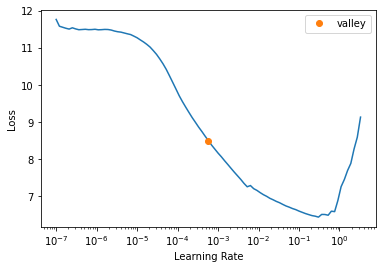

In [14]:
train_submission(epoch_num, batch_size)